In [ ]:
import numpy as np
import shapely

import matplotlib.pyplot as plt
import matplotlib.style as style

style.use(
    "https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle"
)

In [2]:
from dased.layout import DASLayout
from dased.criteria import RaySensitivity

In [ ]:
spacing = 50

side_length = 2_000.0

square_points = np.array(
    [
        [-side_length / 2, -side_length / 2],
        [side_length / 2, -side_length / 2],
        [side_length / 2, side_length / 2],
        [-side_length / 2, side_length / 2],
    ]
)
square_layout = DASLayout(square_points, spacing=spacing, wrap_around=True)

radius = side_length * 4 / (2 * np.pi)
circle_points = np.array(
    [
        [radius * np.cos(theta), radius * np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, num=100, endpoint=False)
    ]
)

circle_layout = DASLayout(circle_points, spacing=spacing, wrap_around=True)

m_points = np.array(
    [
        [-side_length / 2, -side_length / 2],
        [side_length / 2, -side_length / 2],
        [-side_length / 2.7, 0],
        [side_length / 2, side_length / 2],
        [-side_length / 2, side_length / 2],
    ]
)
m_layout = DASLayout(m_points, spacing=spacing)


cross_points = np.array(
    [
        [-side_length / 2, -side_length / 3.35],
        [-side_length / 2, -side_length / 2],
        [0, -side_length / 6],
        [side_length / 2, -side_length / 2],
        [side_length / 6, 0],
        [side_length / 2, side_length / 2],
        [0, side_length / 6],
        [-side_length / 2, side_length / 2],
        [-side_length / 2, side_length / 3.35],
    ]
)
cross_layout = DASLayout(cross_points, spacing=spacing)


In [ ]:
n_points = 30
x_range = (-side_length / 1.5, side_length / 1.5)
y_range = (-side_length / 1.5, side_length / 1.5)

roi = shapely.geometry.Polygon(
    [
        (-side_length / 2, -side_length / 2),
        (side_length / 2, -side_length / 2),
        (side_length / 2, side_length / 2),
        (-side_length / 2, side_length / 2),
    ]
)

rayleigh_sense = RaySensitivity(
    data_type="rayleigh",
    n_points=n_points,
    reference_distance=6000.0,
    roi=roi,
    x_range=x_range,
    y_range=y_range,
    criterion="D",
    criterion_kwargs=dict(threshold=1e-4, penalty=10 * np.log(1e-4), normalize=True),
)

love_sense = RaySensitivity(
    data_type="love",
    n_points=n_points,
    reference_distance=2000.0,
    roi=roi,
    x_range=x_range,
    y_range=y_range,
    criterion="D",
    criterion_kwargs=dict(threshold=1e-4, penalty=10 * np.log(1e-4), normalize=True),
)

In [5]:
from dased.optimisation import DASOptimizationProblem, DASArchipelago

In [ ]:
cable_properties = {
    "cable_length": 8_000.0,
    "spacing": spacing,
    "fixed_points": [
        [-side_length / 2, -side_length / 2],
    ],
}

optimisation_properties = {
    "bounds": [
        [-side_length / 2.0, side_length / 2.0],
        [-side_length / 2.0, side_length / 2.0],
    ],
}
proposal_points = []
proposal_points.append(square_points.tolist())
proposal_points.append(circle_points.tolist())
proposal_points.append(m_points.tolist())
proposal_points.append(cross_points.tolist())

udp_rayleigh = DASOptimizationProblem(
    rayleigh_sense,
    verbose=0,
    k=1,
    N_knots=10,
    **cable_properties,
    **optimisation_properties,
)

archipelago_rayleigh = DASArchipelago(
    udp_rayleigh,
    n_islands=16,
    population_size=128,
    verbose=0,
    random_seed=0,
)

archipelago_rayleigh.initialize(
    proposal_points=proposal_points,
    perturb_proposal=1000.0,
    perturb_knots=500.0,
    corr_len=1000,
    corr_str=0.8,
    show_progress=True,
    filename="data/schematic/tomo_schematic_rayleigh_initialisation",
)

archipelago_rayleigh.optimize(
    n_generations=1000,
    migrate_every=20,
    show_progress=True,
    filename="data/schematic/tomo_schematic_rayleigh_optimisation",
)

udp_love = DASOptimizationProblem(
    love_sense,
    verbose=0,
    k=1,
    N_knots=10,
    **cable_properties,
    **optimisation_properties,
)

archipelago_love = DASArchipelago(
    udp_love,
    n_islands=16,
    population_size=128,
    verbose=0,
    random_seed=0,
)

archipelago_love.initialize(
    proposal_points=proposal_points,
    perturb_proposal=1000.0,
    perturb_knots=500.0,
    corr_len=1000,
    corr_str=0.8,
    show_progress=True,
    filename="data/schematic/tomo_schematic_love_initialisation",
)

archipelago_love.optimize(
    n_generations=1000,
    migrate_every=20,
    show_progress=True,
    filename="data/schematic/tomo_schematic_love_optimisation",
)

Logging level: WARNING


Generating initial population:   0%|          | 0/2048 [00:00<?, ?tasks/s]

In [ ]:
rayleigh_best = archipelago_rayleigh.get_best_single()[0]
love_best = archipelago_love.get_best_single()[0]

In [ ]:
# Generate a checkerboard pattern for slowness
checkerboard_size = 4  # Size of each block in the checkerboard
# Convert velocity to slowness (s/m)
background_velocity = 2000.0  # m/s
perturbation = 0.05  # 5% perturbation

nx, ny = rayleigh_sense.n_points, rayleigh_sense.n_points

m_true = np.ones((nx, ny))
for i in range(nx):
    for j in range(ny):
        if (i // checkerboard_size + j // checkerboard_size) % 2 == 0:
            m_true[i, j] = 1 / (
                background_velocity * (1 - perturbation)
            )  # Background slowness
        else:
            m_true[i, j] = 1 / (background_velocity * (1 + perturbation))
m_prior = np.ones((nx, ny)) / background_velocity

In [ ]:
x_nodes = np.linspace(x_range[0], x_range[1], nx + 1)
y_nodes = np.linspace(y_range[0], y_range[1], ny + 1)

X, Y = np.meshgrid(x_nodes, y_nodes, indexing="ij")
coord_list = np.stack([X.flatten(), Y.flatten()], axis=1)
# Get mask for centers of the cells (not the nodes)
x_centers = (x_nodes[:-1] + x_nodes[1:]) / 2
y_centers = (y_nodes[:-1] + y_nodes[1:]) / 2
Xc, Yc = np.meshgrid(x_centers, y_centers, indexing="ij")

roi_mask = np.zeros((nx, ny), dtype=bool)
for i in range(nx):
    for j in range(ny):
        point = shapely.geometry.Point(Xc[i, j], Yc[i, j])
        if roi.contains(point):
            roi_mask[i, j] = True

In [ ]:
from dased.criteria.RaySensitivity import get_gaussian_prior

noise_cov = 0.001


grid_spacing = (
    (x_range[1] - x_range[0]) / n_points,
    (y_range[1] - y_range[0]) / n_points,
)

correlation_length = 50.0
correlation_weight = 100

Cm = get_gaussian_prior(correlation_length, n_points, n_points, grid_spacing)

Cm *= correlation_weight**2
Cm_inv = np.linalg.inv(Cm.toarray()).copy()


criteria_dict = dict(
    rayleigh_a=RaySensitivity(
        data_type="rayleigh",
        n_points=n_points,
        reference_distance=6000.0,
        roi=roi,
        x_range=x_range,
        y_range=y_range,
        criterion="A",
        criterion_kwargs=dict(normalize=True),
    ),
    rayleigh_d=RaySensitivity(
        data_type="rayleigh",
        n_points=n_points,
        reference_distance=6000.0,
        roi=roi,
        x_range=x_range,
        y_range=y_range,
        criterion="D",
        criterion_kwargs=dict(
            threshold=1e-4, penalty=10 * np.log(1e-4), normalize=True
        ),
    ),
    rayleigh_rer=RaySensitivity(
        data_type="rayleigh",
        n_points=n_points,
        reference_distance=6000.0,
        roi=roi,
        x_range=x_range,
        y_range=y_range,
        criterion="RER",
        criterion_kwargs=dict(threshold=1e-5),
    ),
    love_a=RaySensitivity(
        data_type="love",
        n_points=n_points,
        reference_distance=2000.0,
        roi=roi,
        x_range=x_range,
        y_range=y_range,
        criterion="A",
        criterion_kwargs=dict(normalize=True),
    ),
    love_d=RaySensitivity(
        data_type="love",
        n_points=n_points,
        reference_distance=2000.0,
        roi=roi,
        x_range=x_range,
        y_range=y_range,
        criterion="D",
        criterion_kwargs=dict(
            threshold=1e-4, penalty=10 * np.log(1e-4), normalize=True
        ),
    ),
    love_rer=RaySensitivity(
        data_type="love",
        n_points=n_points,
        reference_distance=2500.0,
        roi=roi,
        x_range=x_range,
        y_range=y_range,
        criterion="RER",
        criterion_kwargs=dict(threshold=1e-5),
    ),
)

In [ ]:
layout_dict = {
    "square": square_layout,
    "m": m_layout,
    "optimised_rayleigh": rayleigh_best,
    "optimised_love": love_best,
}

# Calculate criteria for each layout and display results
results = {}

for layout_name, layout in layout_dict.items():
    results[layout_name] = {}

    # Determine which criteria to use based on layout type
    if "optimised_rayleigh" in layout_name:
        criteria_subset = {k: v for k, v in criteria_dict.items() if "rayleigh" in k}
    elif "optimised_love" in layout_name:
        criteria_subset = {k: v for k, v in criteria_dict.items() if "love" in k}
    else:
        # For square and m layouts, use all criteria
        criteria_subset = criteria_dict

    for criterion_name, criterion in criteria_subset.items():
        try:
            value = criterion(layout)
            results[layout_name][criterion_name] = value
        except Exception as e:
            results[layout_name][criterion_name] = f"Error: {str(e)}"

# Print results in a nicely formatted table
print("Criteria Evaluation Results")
print("=" * 80)

for layout_name, layout_results in results.items():
    print(f"\n{layout_name.upper().replace('_', ' ')}:")
    print("-" * 40)
    for criterion_name, value in layout_results.items():
        if isinstance(value, (int, float)):
            print(f"  {criterion_name:15}: {value:.6f}")
        else:
            print(f"  {criterion_name:15}: {value}")

Criteria Evaluation Results

SQUARE:
----------------------------------------
  rayleigh_a     : 14.146558
  rayleigh_d     : 0.280162
  rayleigh_rer   : 0.280992
  love_a         : 18.611133
  love_d         : 0.484459
  love_rer       : 0.669421

M:
----------------------------------------
  rayleigh_a     : 6.269121
  rayleigh_d     : 0.396177
  rayleigh_rer   : 0.400826
  love_a         : 17.581643
  love_d         : 0.440733
  love_rer       : 0.611570

OPTIMISED RAYLEIGH:
----------------------------------------
  rayleigh_a     : 22.144761
  rayleigh_d     : 0.941617
  rayleigh_rer   : 0.987603

OPTIMISED LOVE:
----------------------------------------
  love_a         : 30.641221
  love_d         : 0.944779
  love_rer       : 0.985537


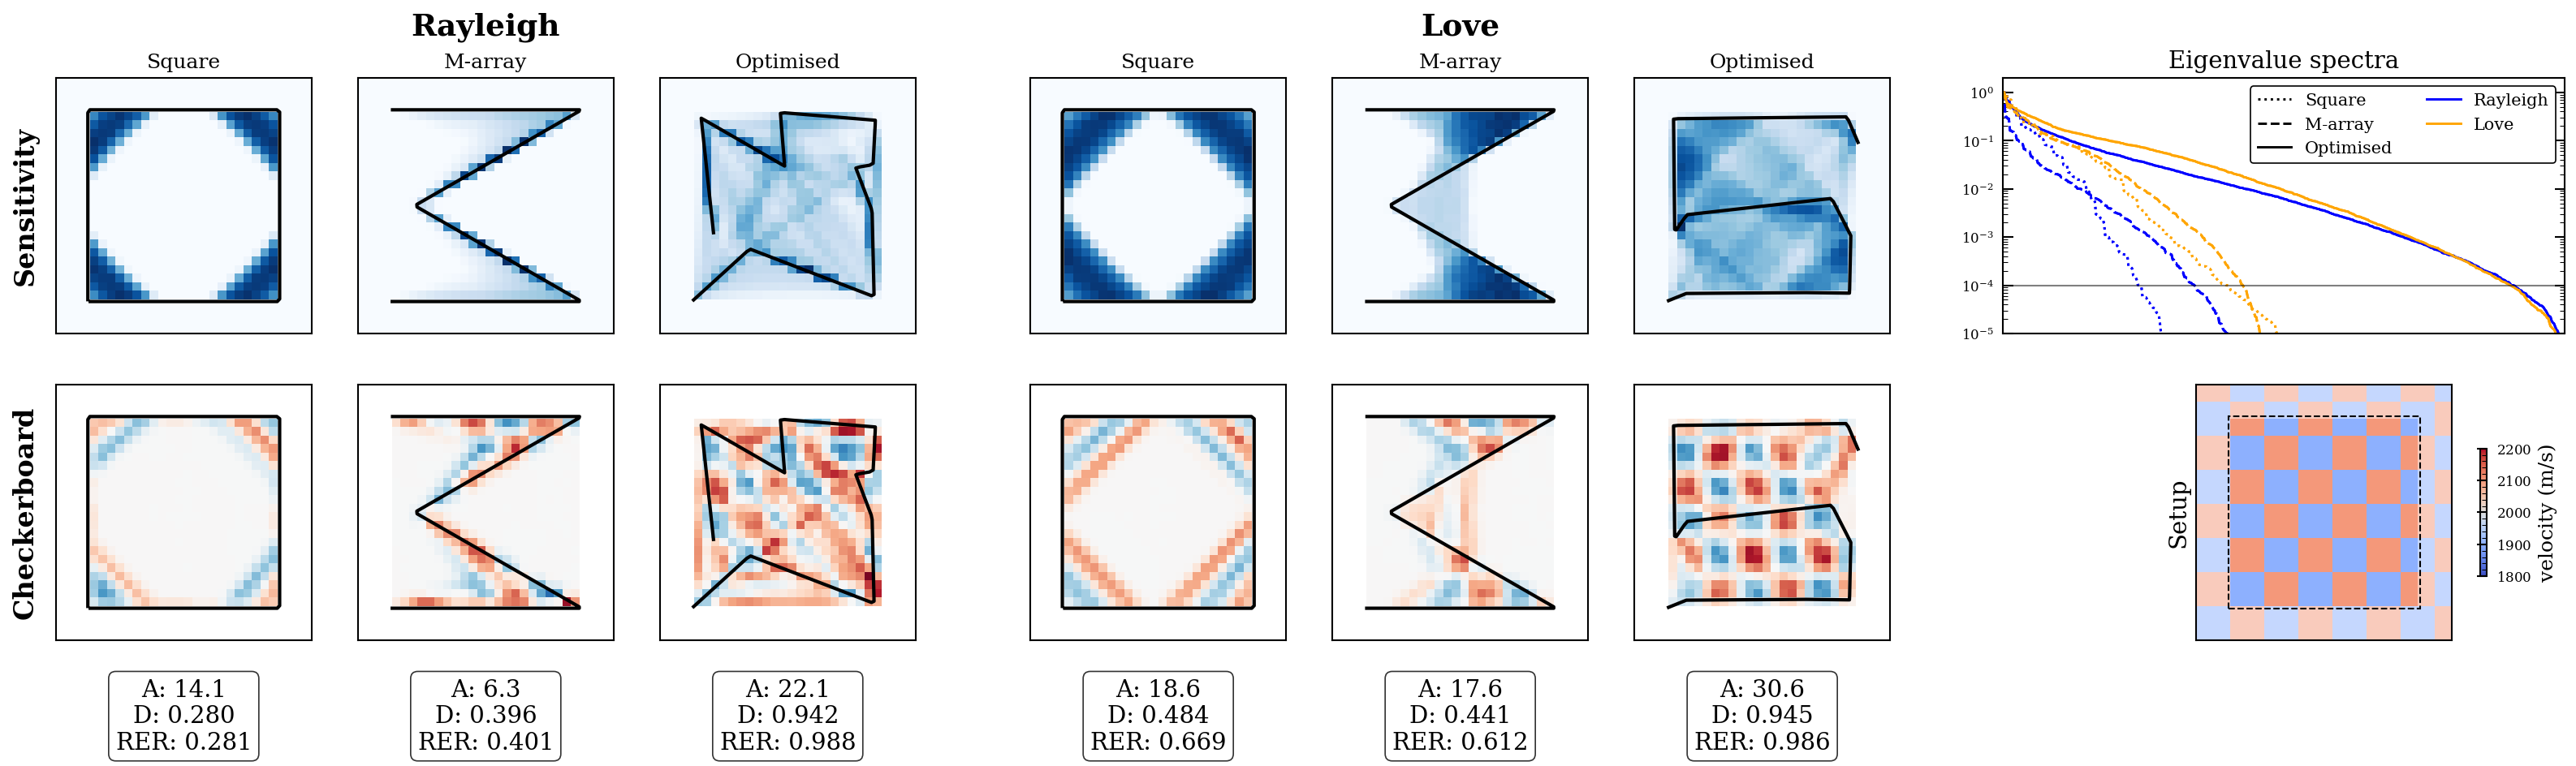

In [ ]:
# mosaic_list = [
#     ['square_rayleigh_grad', 'm_rayleigh_grad', 'cross_rayleigh_grad', 'square_love_grad', 'm_love_grad', 'cross_love_grad', 'eigenvalue'],
#     ['square_rayleigh_chess', 'm_rayleigh_chess', 'cross_rayleigh_chess', 'square_love_chess', 'm_love_chess', 'cross_love_chess', 'setup'],
# ]

optimised_dict = {
    "rayleigh": rayleigh_best,
    "love": love_best,
}

layout_list = ["square", "m", "optimised"]
wave_list = ["rayleigh", "love"]
mosaic_list = []

for pt in ["grad", "chess"]:
    temp_list = []
    for wave in wave_list:
        for layout in layout_list:
            temp_list.append(f"{layout}_{wave}_{pt}")
        temp_list.append(".")

    if pt == "grad":
        temp_list += ["eigenvalue", "eigenvalue"]
    else:
        temp_list += ["setup", "setup"]

    mosaic_list.append(temp_list)

layout_dict = {
    "square": square_layout,
    "m": m_layout,
    "circle": circle_layout,
    "cross": cross_layout,
}
name_dict = {"rayleigh": "Rayleigh", "love": "Love"}
wave_dict = {"rayleigh": rayleigh_sense, "love": love_sense}

fig, ax_dict = plt.subplot_mosaic(
    mosaic_list,
    figsize=(2.2 * len(mosaic_list[0]) + 4.6, 2.0 * len(mosaic_list) + 2.0),
    empty_sentinel=".",
    width_ratios=[1] * len(layout_list)
    + [0.1]
    + [1] * len(layout_list)
    + [0.1, 1.0, 1.0],
    height_ratios=[1, 1],
)

fig.set_facecolor("white")

label_map = {
    "square": "Square",
    "m": "M-array",
    "cross": "Cross",
    "optimised": "Optimised",
}

eigenvalue_spectra_dict = {}

for key, ax in ax_dict.items():
    if key == "setup":
        pass
    elif key == "eigenvalue":
        pass
    else:
        layout_name = key.split("_")[0]
        wave_type = key.split("_")[1]
        wave_class = wave_dict[wave_type]

        if layout_name != "optimised":
            layout = layout_dict[layout_name]
        else:
            layout = optimised_dict[wave_type]

        plot_type = key.split("_")[2]

        if plot_type == "grad":
            wave_class.plot(layout, ax=ax)
        elif plot_type == "chess":
            wave_class.plot_checkerboard(
                layout,
                ax=ax,
                background_velocity=background_velocity,
                perturbation=perturbation,
                checkerboard_size=checkerboard_size,
                vmin=1800,
                vmax=2200,
                sigma_d=0.001,
                correlation_length=50,
                regularization_weight=2.5e-6,
            )

            # Add metrics text below chess plots
            if layout_name == "optimised":
                result_key = f"optimised_{wave_type}"
            else:
                result_key = layout_name

            if result_key in results:
                if layout_name == "optimised":
                    # For optimised layouts, only show the relevant wave type metrics
                    a_val = results[result_key][f"{wave_type}_a"]
                    d_val = results[result_key][f"{wave_type}_d"]
                    rer_val = results[result_key][f"{wave_type}_rer"]
                else:
                    # For square and m layouts, show metrics for the current wave type
                    a_val = results[result_key][f"{wave_type}_a"]
                    d_val = results[result_key][f"{wave_type}_d"]
                    rer_val = results[result_key][f"{wave_type}_rer"]

                # Add text below the plot
                ax.text(
                    0.5,
                    -0.15,
                    f"A: {a_val:.1f}\nD: {d_val:.3f}\nRER: {rer_val:.3f}",
                    transform=ax.transAxes,
                    ha="center",
                    va="top",
                    fontsize=14,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                )

        layout.plot(ax=ax, color="black", plot_style="line", linewidth=2.0)

        ax.set_xlim(-side_length / 1.5, side_length / 1.5)
        ax.set_ylim(-side_length / 1.5, side_length / 1.5)

        ax.set_aspect("equal")

        if plot_type == "grad":
            ax.set_title(f"{label_map[layout_name]}", fontsize=12)

        if key == f"{layout_list[0]}_{wave_list[0]}_grad":
            ax.set_ylabel("Sensitivity", fontsize=16, fontweight="bold", labelpad=10)
        if key == f"{layout_list[0]}_{wave_list[0]}_chess":
            ax.set_ylabel("Checkerboard", fontsize=16, fontweight="bold", labelpad=10)

        eigenvalue_spectra_dict[key] = wave_class.get_eigenvalue_spectrum(layout)
        eigenvalue_spectra_dict[key] = np.array(eigenvalue_spectra_dict[key])

    ax.set_xticks([])
    ax.set_yticks([])
# Plot a single title over all columns with 'rayleigh' in their key
# Find all axes with 'rayleigh' in their key and get their positions
rayleigh_keys = [k for k in ax_dict if "rayleigh" in k]
rayleigh_axes = [ax_dict[k] for k in rayleigh_keys]
if rayleigh_axes:
    # Get bounding box covering all rayleigh axes
    fig.canvas.draw()  # Needed to ensure positions are updated
    bboxes = [ax.get_position() for ax in rayleigh_axes]
    min_x = min(b.x0 for b in bboxes)
    max_x = max(b.x1 for b in bboxes)
    max_y = max(b.y1 for b in bboxes)
    # Place the title above the topmost rayleigh axes
    fig.text(
        (min_x + max_x) / 2,
        max_y + 0.05,
        "Rayleigh",
        ha="center",
        va="bottom",
        fontsize=18,
        fontweight="bold",
    )
# Plot a single title over all columns with 'love' in their key
love_keys = [k for k in ax_dict if "love" in k]
love_axes = [ax_dict[k] for k in love_keys]
if love_axes:
    # Get bounding box covering all love axes
    fig.canvas.draw()  # Needed to ensure positions are updated
    bboxes = [ax.get_position() for ax in love_axes]
    min_x = min(b.x0 for b in bboxes)
    max_x = max(b.x1 for b in bboxes)
    max_y = max(b.y1 for b in bboxes)
    # Place the title above the topmost love axes
    fig.text(
        (min_x + max_x) / 2,
        max_y + 0.05,
        "Love",
        ha="center",
        va="bottom",
        fontsize=18,
        fontweight="bold",
    )

ax_dict["eigenvalue"].set_title("Eigenvalue spectra", fontsize=14)

color_dict = {
    "Rayleigh": "blue",
    "Love": "orange",
}
line_style_dict = {"square": ":", "m": "--", "cross": "=.", "optimised": "-"}

for key, es in eigenvalue_spectra_dict.items():
    if key == "setup":
        continue
    elif key == "eigenvalue":
        continue
    else:
        layout_name = key.split("_")[0]
        wave_type = key.split("_")[1]

        ax = ax_dict["eigenvalue"]

        if layout_name == "m":
            label = f"{name_dict[wave_type]} {layout_name.capitalize()}"
        else:
            label = f"{name_dict[wave_type]} {layout_name.capitalize()}"

        ax.plot(
            np.linspace(0, 1, len(es)),
            es,
            color=color_dict[name_dict[wave_type]],
            linestyle=line_style_dict[layout_name],
        )

for line_style_dict_key, line_style in line_style_dict.items():
    if line_style_dict_key not in layout_list:
        continue
    ax_dict["eigenvalue"].plot(
        [], [], color="k", linestyle=line_style, label=label_map[line_style_dict_key]
    )

for color_dict_key, color in color_dict.items():
    ax_dict["eigenvalue"].plot([], [], color=color, label=color_dict_key)

ax_dict["eigenvalue"].set_yscale("log")
# ax_dict['eigenvalue'].set_yticks([])
ax_dict["eigenvalue"].set_ylim(1e-5, 2)
ax_dict["eigenvalue"].set_xlim(0, 1)

# ax_dict['eigenvalue'].legend(
#     bbox_to_anchor=(0.8, -0.1), loc='upper center', fontsize=14)
ax_dict["eigenvalue"].legend(
    loc="upper right", fontsize=10, borderaxespad=0.5, facecolor="white", ncol=2
)

ax_dict["eigenvalue"].axhline(
    y=1e-4,
    color="black",
    linestyle="-",
    linewidth=1.0,
    alpha=0.5,
)

m_interest = m_true.copy()
m_interest[~roi_mask] = np.nan
pcm1 = ax_dict["setup"].pcolormesh(
    X,
    Y,
    1 / m_interest,
    cmap="coolwarm",
    vmin=1800,
    vmax=2200,
)
m_out = m_true.copy()
m_out[roi_mask] = np.nan
pcm2 = ax_dict["setup"].pcolormesh(
    X,
    Y,
    1 / m_out,
    cmap="coolwarm",
    vmin=1800,
    vmax=2200,
    alpha=0.5,
)
# colorbar
cbar = fig.colorbar(pcm1, ax=ax_dict["setup"], shrink=0.5, pad=0.05)
cbar.set_label("velocity (m/s)", fontsize=12)

rect = plt.Rectangle(
    (-side_length / 2, -side_length / 2),
    side_length,
    side_length,
    linewidth=1,
    edgecolor="black",
    facecolor="none",
    linestyle="--",
)
ax_dict["setup"].add_patch(rect)

ax_dict["setup"].set_xlim(-side_length / 1.5, side_length / 1.5)
ax_dict["setup"].set_ylim(-side_length / 1.5, side_length / 1.5)
ax_dict["setup"].set_xticks([])
ax_dict["setup"].set_yticks([])
ax_dict["setup"].set_aspect("equal")
ax_dict["setup"].set_ylabel("Setup", fontsize=14)


fig.savefig("figures/tomo_schematic.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/tomo_schematic.pdf", dpi=300, bbox_inches="tight")

plt.show()